# Formação Cientista de Dados
## Data Science Academy
### Projetos com Feedback

04 - Prevendo Customer Churn em Operadoras de Telecom

Trabalhando com dois datasets (treino e teste) disponibilizados pela DSA, o objetivo é identificar a % de rotatividade de clientes, buscando entender se a perda de clientes está alta e se esses clientes compõem o grupo que gera mais receita para a empresa (regra de lucratividade do cliente 80/20, na qual 20% dos clientes geram 80% da receita).

Linguagem: python

Algoritmo de Machine Learning: Regressão Logística

Resultados: Classificação binária, se um cliente vai ou não encerrar o relacionamento (0 ou 1/ Sim ou Não) e a probabilidade de cada opção.

In [1]:
# Não mostrando avisos
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Pacotes necessários
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from scikitplot.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle

In [3]:
# Definindo estilo e cores para os gráficos
sns.set(context="notebook", style="darkgrid", palette="dark")

__Carregando e compreendendo dados__

In [4]:
dados = pd.read_csv('datasets/projeto4_telecom_treino.csv', index_col = 0)

In [5]:
# Amostra do dataset
dados.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [6]:
# Formato do dataset: 3333 linhas e 20 colunas
dados.shape

(3333, 20)

In [7]:
# Algumas estatísticas descritivas do dataset
dados.describe(include = 'all')

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
count,3333,3333.000000,3333,3333,3333,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333
unique,51,NaN,3,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,WV,NaN,area_code_415,no,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
freq,106,NaN,1655,3010,2411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2850
mean,NaN,101.064806,NaN,NaN,NaN,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,NaN
std,NaN,39.822106,NaN,NaN,NaN,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,NaN
min,NaN,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,74.000000,NaN,NaN,NaN,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,NaN
50%,NaN,101.000000,NaN,NaN,NaN,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,NaN
75%,NaN,127.000000,NaN,NaN,NaN,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,NaN


Dicionário de dados

In [8]:
descricao = ['Estado dos EUA no qual o cliente reside', 'Número de dias que a conta está ativa', \
             'Código da área correspondente à localização do cliente', 'Se o cliente possui ou não plano internacional', \
             'Se o cliente possui ou não plano de voz', 'Número de menssagens de voz realizadas', \
             'Total de minutos falados durante o dia', 'Total de chamadas realizadas durante o dia', \
             'Total pago por chamadas realizadas durante o dia', 'Total de minutos falados no início da noite', \
             'Total de chamadas realizadas no início da noite', 'Total pago por ligações realizadas no início da noite', \
             'Total de minutos falados no fim da noite', 'Total de chamadas realizadas no fim da noite', \
             'Total pago por ligações realizadas no fim da noite', 'Total de minutos falados em chamadas internacionais', \
             'Total de chamadas internacionais realizadas', 'Total cobrado por chamadas internacionais', \
             'Número de chamadas feitas para o atendimento ao cliente', 'Se o cliente cancelou ou não o serviço']

In [9]:
valores_permitidos = ['string', 'números inteiros', 'string', 'string', 'string', 'números inteiros', \
                                    'números decimais', 'números inteiros', 'números decimais', 'números decimais', \
                                    'números inteiros', 'números decimais', 'números decimais', \
                                    'números inteiros', 'números decimais', 'números decimais', \
                                    'números inteiros', 'números decimais', 'números inteiros', 'string']

In [10]:
dicionario = {'Coluna': [dados.columns[i] for i in range(20)], \
              'Descrição': descricao, \
              'Tipo de dado': [dados.dtypes[i] for i in range(20)], \
              'Valores permitidos': valores_permitidos}

In [11]:
# Aumentando tamanho da coluna para melhorar visualização do dataframe com o dicionário de dados
pd.set_option('max_colwidth', 100)

In [12]:
dicionario_dados = pd.DataFrame(dicionario); dicionario_dados

,Coluna,Descrição,Tipo de dado,Valores permitidos
0,state,Estado dos EUA no qual o cliente reside,object,string
1,account_length,Número de dias que a conta está ativa,int64,números inteiros
2,area_code,Código da área correspondente à localização do cliente,object,string
3,international_plan,Se o cliente possui ou não plano internacional,object,string
4,voice_mail_plan,Se o cliente possui ou não plano de voz,object,string
5,number_vmail_messages,Número de menssagens de voz realizadas,int64,números inteiros
6,total_day_minutes,Total de minutos falados durante o dia,float64,números decimais
7,total_day_calls,Total de chamadas realizadas durante o dia,int64,números inteiros
8,total_day_charge,Total pago por chamadas realizadas durante o dia,float64,números decimais
9,total_eve_minutes,Total de minutos falados no início da noite,float64,números decimais


In [ ]:
# Salvando dicionário de dados para disponibilizar no projeto
dicionario_dados.to_csv('dicionario_dados.csv', sep = ';')

In [13]:
# Voltando com o tamanho normal das colunas
pd.reset_option('max_colwidth')

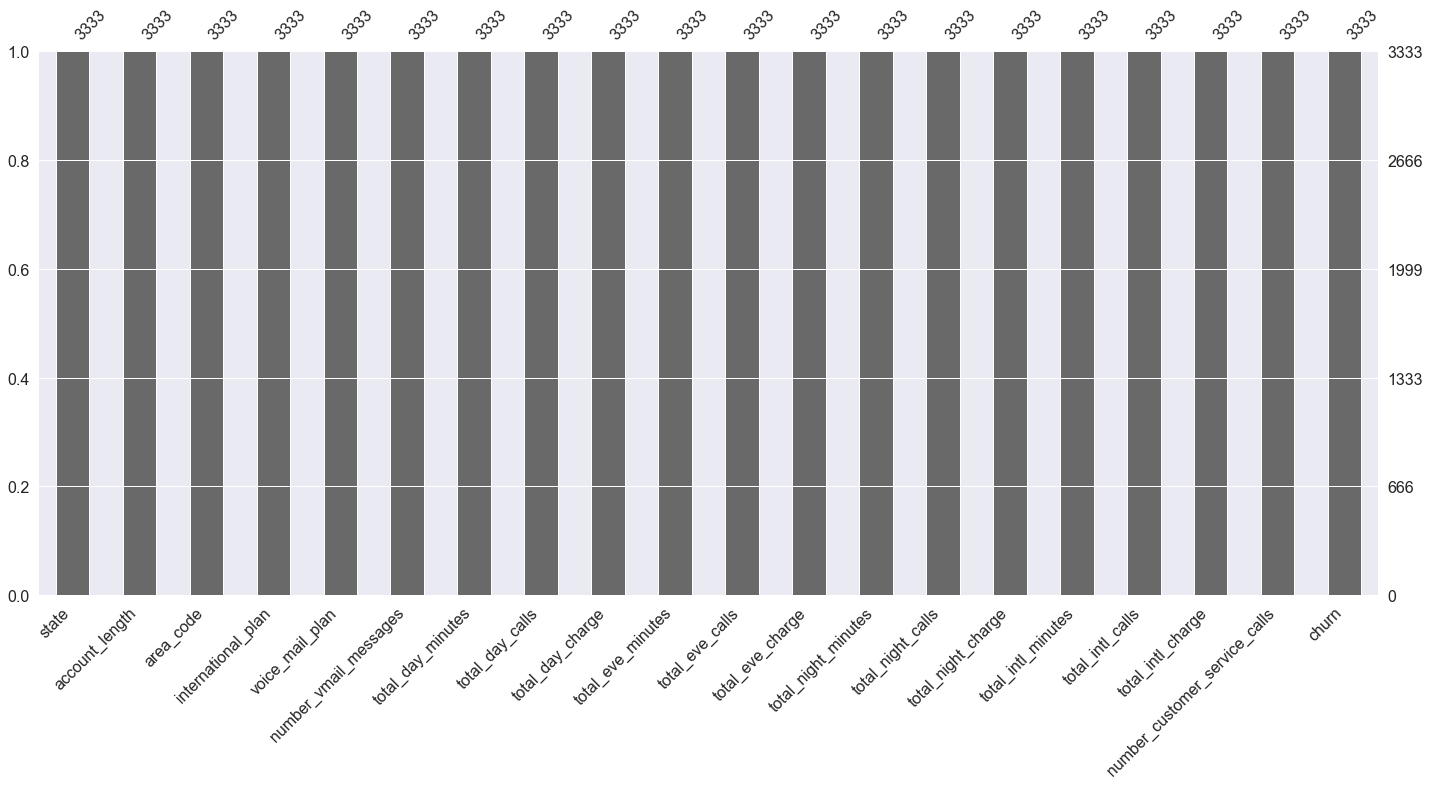

In [14]:
# Gráfico para expor valores nulos ou data missing

# Defininido área de plotagem
fig = plt.gcf()

# Construção do gráfico
msno.bar(dados)

# Mostrar gráfico
plt.show()

Anteriormente conferimos o shape do dataset (linhas = 3333, colunas = 20).

Neste sentido, a partir do gráfico acima, concluimos que o dataset não possui valores nulos.

(todas as 20 colunas, representadas pelas barras, possuem 3333 valores cada)

In [ ]:
# Salvando plot
fig.savefig("plots/missing-data.png")

__Preparando dados para análise exploratória__

In [15]:
# Limpando coluna de código de área
codigos = []

for i in dados.area_code:
    codigos.append(i[-3:])

dados.area_code = codigos

In [16]:
# Transformando devidas coluna em categóricas
# state, area_code, international_plan, voice_mail_plan
# mesmo necessário?
dados[['area_code', 'international_plan', 'voice_mail_plan']] = \
dados[['area_code', 'international_plan', 'voice_mail_plan']].astype('category')

In [17]:
# Criando colunas com totais de minutos, totais de chamadas e total pago por cliente
dados['total_minutes'] = dados.total_day_minutes + dados.total_eve_minutes + dados.total_night_minutes + dados.total_intl_minutes

dados['total_calls'] = dados.total_day_calls + dados.total_eve_calls + dados.total_night_calls + dados.total_intl_calls

dados['total_charge'] = dados.total_day_charge + dados.total_eve_charge + dados.total_night_charge + dados.total_intl_charge

In [18]:
# Criando coluna com período do dia mais utilizado pelo cliente
# linha 6: minutos dia
# linha 9: minutos noite
# linha 12: minutos madrugada
periodo = []
for linha in dados.values:
    #print(linha[6], linha[9], linha[12])
    if linha[6] > linha[9] or linha[6] > linha[12]:
        periodo.append('dia')
    elif linha[9] > linha[6] or linha[9] > linha[12]:
        periodo.append('noite')
    else:
        periodo.append('madrugada')

dados['periodo'] = periodo

In [19]:
# Criando coluna com churn rate
# Churn rate = nº de clientes que cancelaram seus planos / nº de clientes total da localidade

# Contabilizando clientes que cancelam e que permanecem ativos
churn_rate = pd.crosstab(dados.state, dados.churn)

# Calculando rate de clientes ativos (churn rate)
churn_rate['rate'] = round((churn_rate['yes'] / (churn_rate['no'] + churn_rate['yes'])), 3)

# Criando dataframe com os states e as rates
churn_rate = pd.DataFrame({'state': churn_rate.index, 'rate': churn_rate.rate})
churn_rate = churn_rate.set_index(pd.Index(range(1, 52)))

# Inserindo churn_rate no dataset
rates = []
for linha in dados.values:
    local = linha[0]
    rates.append(float(churn_rate.rate.values[churn_rate.state.values == local]))
    
dados['churn_rate'] = rates

In [20]:
# Amostra do dataset após transformações
dados.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_calls,total_charge,periodo,churn_rate
1,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,10.0,3,2.70,1,no,717.2,303,75.56,dia,0.186
2,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,13.7,3,3.70,1,no,625.2,332,59.24,noite,0.128
3,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,12.2,5,3.29,0,no,539.4,333,62.29,dia,0.265
4,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,6.6,7,1.78,2,no,564.8,255,66.80,dia,0.128
5,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,10.1,3,2.73,3,no,512.0,359,52.09,dia,0.148


__Análise Exploratória__

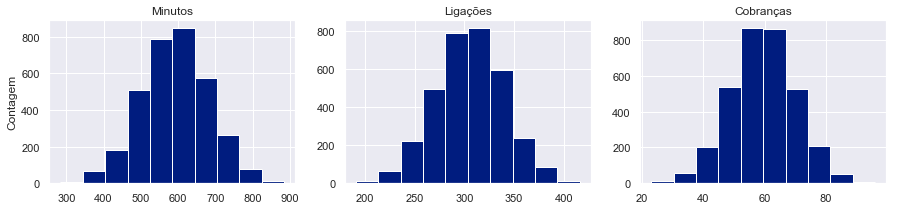

In [21]:
# Distribuição de minutos, ligações e cobranças (histogramas)

# Definição da espaço de plotagem
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# Gráfico 1 - minutos
ax[0].hist(dados.total_minutes)
ax[0].set_title('Minutos')
ax[0].set_ylabel('Contagem')

# Gráfico 2 - quantidade de ligações
ax[1].hist(dados.total_calls)
ax[1].set_title('Ligações')

# Gráfico 3 - valor das cobranças
ax[2].hist(dados.total_charge)
ax[2].set_title('Cobranças')

# Mostrar gráficos
plt.show()

Podemos observar que o total de minutos, quantidade de ligações e valor cobrado nas contas segue uma distribuição normal.

Além disso, observamos que os clientes, em sua maioria, realizam entre 260 e 350 ligações ligações mensais, com durações de 450 à 700 minutos e gastam entre 50 e 70 dólares.

In [ ]:
# Salvando plot
fig.savefig("plots/histograma.png")

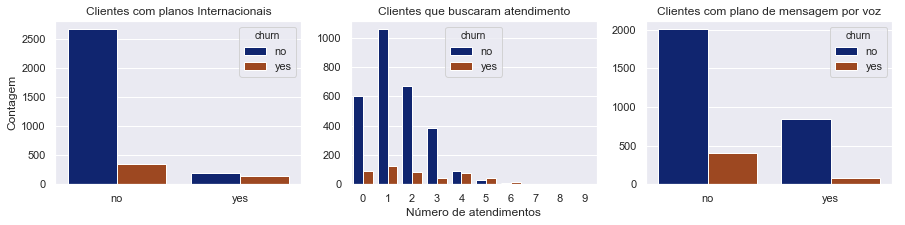

In [22]:
# Características dos clientes ativos e dos clientes que cancelaram seus planos

# Definição da espaço de plotagem
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# Gráfico de barras com informação se o cliente possui ou não plano internacional dividido por clientes que
# encerraram relacionamento e clientes que se mantiveram ativos (churn = 1, churn = 0)
sns.countplot(x = 'international_plan', hue = 'churn', data = dados, ax = ax[0])
ax[0].set_title('Clientes com planos Internacionais')
ax[0].set_ylabel('Contagem')
ax[0].set_xlabel('')

# Gráfico de barras com numero de clientes que buscou atendimento (coluna number_customer_service_calls) dividido por
# clientes que encerraram relacionamento e clientes que se mantiveram ativos (churn = 1, churn = 0)
sns.countplot(x = 'number_customer_service_calls', hue = 'churn', data = dados, ax = ax[1])
ax[1].set_title('Clientes que buscaram atendimento')
ax[1].set_ylabel('')
ax[1].set_xlabel('Número de atendimentos')

# Gráfico de barras com informação se o cliente possui ou não plano de menssagem por voz dividido por clientes que
# encerraram relacionamento e clientes que se mantiveram ativos (churn = 1, churn = 0)
sns.countplot(x = 'voice_mail_plan', hue = 'churn', data = dados, ax = ax[2])
ax[2].set_title('Clientes com plano de mensagem por voz')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

# Mostrar gráficos
plt.show()

Observamos que, aparentemente, não há impacto relevante na escolha do cliente pelo desligamento quando analisamos a contratação de planos por voz. A proporção de clientes que opta pelo cancelamento em relação aos que se mantém ativos é parecida para aqueles que possuem ou não planos de voz.

Analisando, no entanto, os clientes que possuem planos internacionais, observamos que a diferença entre os clientes que optaram pelo desligamento e os que não optaram é muito menor. Revisar valores e benefícios dos planos internacionais pode ser uma boa opção a fim de reduzir o churn deste grupo. Ainda mais porque planos internacionais são sempre mais caros e podem estar repletos de clientes que compõe os 20% que correspondem aos 80% da receita na regra da lucratividade.

Em relação ao churn dos clientes que buscaram atendimento, observamos altos números de não cancelamento naqueles que por poucas vezes entraram em contato com a empresa. Para os clientes que recorreram ao atendimento até 4x, o churn encontra-se bem menor e, a partir de 5 atendimentos, os clientes parecem não estar satisfeitos, observando mais clientes que cancelaram seus planos em detrimento dos que não cancelaram.

In [ ]:
# Salvando plot
fig.savefig("plots/clients-caracteristics.png")

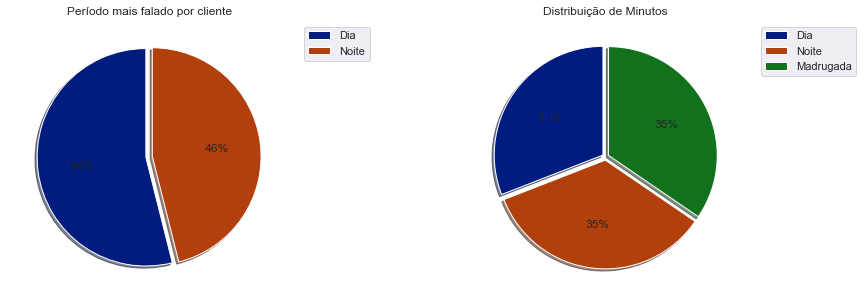

In [23]:
# Período do dia mais falado e distribuição de minutos

# definição da área de plotagem
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Período mais falado
ax[0].pie(dados.periodo.value_counts(), startangle = 90, shadow = True, autopct='%.0f%%', explode = [.03,.03])
ax[0].legend(['Dia', 'Noite'], bbox_to_anchor = (1.05, 1))
ax[0].set_title("Período mais falado por cliente")

# Distribuição de minutos
valores = [dados.total_day_minutes.sum(), dados.total_eve_minutes.sum(), dados.total_night_minutes.sum()]
ax[1].pie(valores, startangle = 90, shadow = True, autopct='%.0f%%', explode = [.03,.03, .03])
ax[1].legend(['Dia', 'Noite', 'Madrugada'], bbox_to_anchor = (1.05, 1))
ax[1].set_title("Distribuição de Minutos")

# Mostrar gráficos
plt.show()

No primeiro gráfico, observamos que o período do dia é o mais frequente entre os clientes. Tendo em vista que o períod da madrugada sequer apareceu, concluímos também que nenhum dos clientes utiliza, em sua maioria, este período para realizar ligações.

No segundo gráfico, observamos a distribuição de minutos de ligações de acordo com o período. Nele observamos que os três períodos são usados de maneira equilibrada pelos clientes, insight que não foi possível obter no gráfico anterior.

In [ ]:
# Salvando plot
fig.savefig("plots/periodo.png")

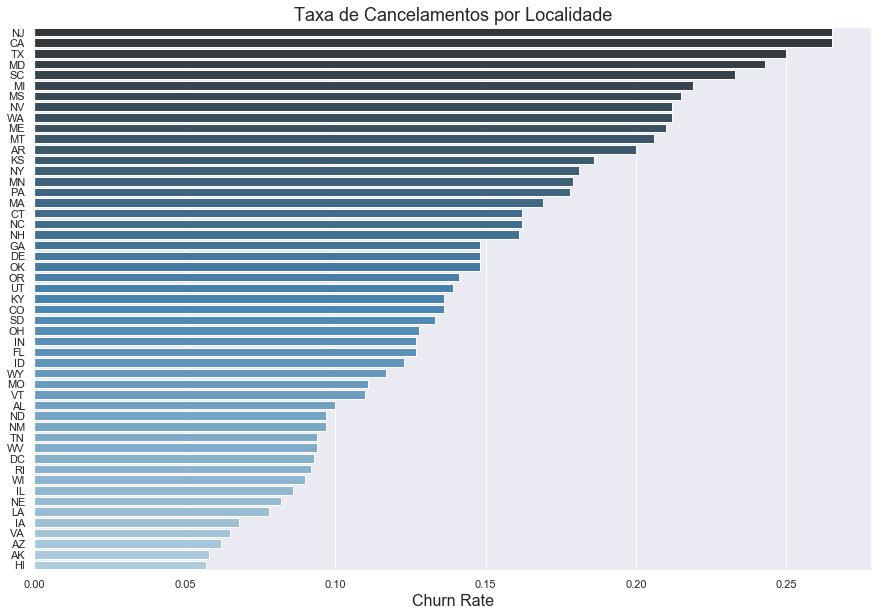

In [24]:
# Ranking de churn rate por localidade

# Construindo dataframe com as taxas de cancelamento por localidade em ordem decrescente
y = pd.DataFrame(dados.groupby('state')['churn_rate'].mean().rename('Taxa').sort_values(ascending = False))
y = y.reset_index()

# Defininido área de plotagem
fig, ax = plt.subplots(figsize = (15, 10))

# Construindo o gráfico
sns.barplot(x = 'Taxa', y = 'state', data = y, palette = 'Blues_d')
plt.title('Taxa de Cancelamentos por Localidade', fontsize = 18)
plt.xlabel('Churn Rate', fontsize = 16)
plt.ylabel('')

# Mostrar gráfico
plt.show()

NI, CA e TX lideram o ranking como as localidades que mais sofreram com altas taxas de churn, enquanto AZ, AK e HI parecem ter clientes mais fiéis.

In [ ]:
# Salvando plot
fig.savefig("plots/churn-rate-local.png")

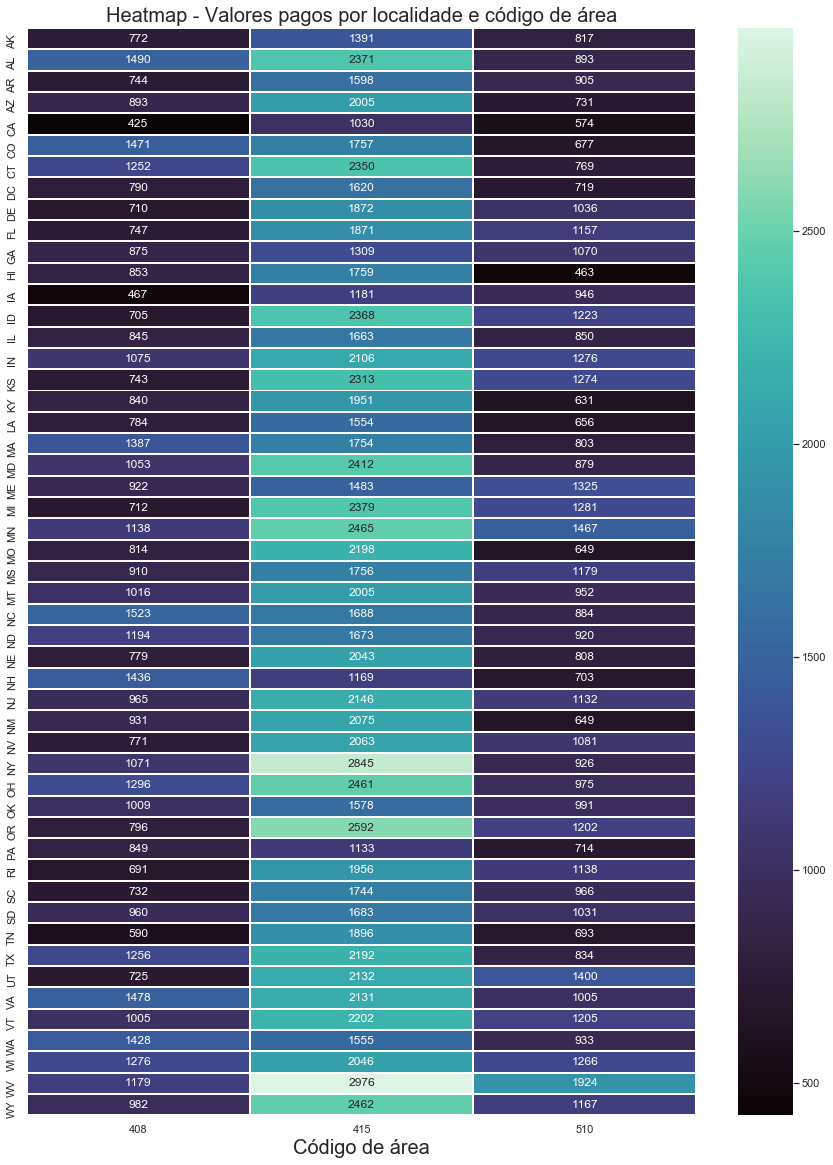

In [25]:
# Áreas que mais gastaram
# Mapa de Calor (state = y, codigo de area = x, total pago = valor)

# Agrupamento dos valores pagos por localidade e código de área
x = pd.DataFrame(dados.groupby(['state', 'area_code'])['total_charge'].sum().rename('Soma de valores pagos'))
x = x.reset_index()

# Pivot da tabela acima para preenchimento do mapa de calor
x_pivot = x.pivot('state', 'area_code', 'Soma de valores pagos')
x_pivot = x_pivot.astype(int)

# Definição da área de plotagem
fig, ax = plt.subplots(figsize = (15, 20))

# Construção do gráfico
sns.heatmap(x_pivot, linewidths = 1, annot = True, fmt="d", cmap = 'mako')
ax.set_title('Heatmap - Valores pagos por localidade e código de área', fontsize = 20)
ax.xaxis.set_label_text('Código de área', fontsize = 20)
ax.yaxis.set_label_text('')

# Mostrar gráfico
plt.show()

Com o mapa de calor, podemos observar que os clientes que mais contribuem para receita utilizam código de área 415 e falam das localidades NY (USD 2845) e WV (USD 2976).

In [ ]:
# Salvando plot
fig.savefig("plots/heatmap-valor-local.png")

__Pré Processamento dos dados__

Transformações e retiradas de colunas

In [26]:
# Transformando variável target e demais categóricas em numéricas para 
# procedimentos de pré-processamento e treinamento do modelo
dados.churn = [1 if item == 'yes' else 0 for item in dados.churn]
dados.international_plan = [1 if item == 'yes' else 0 for item in dados.international_plan]
dados.voice_mail_plan = [1 if item == 'yes' else 0 for item in dados.voice_mail_plan]

In [27]:
# Transformando a coluna state em churn_rate
for i in list(dados.state.values):
    if i in list(churn_rate.state):
        dados.state.values[dados.state == i] = churn_rate.rate.values[churn_rate.state == i]

dados = dados.drop('churn_rate', axis = 1)

In [28]:
# Retirando do modelo a ser treinado as colunas area_code (não necessária no treinamento do modelo)
# e total_minutes, total_calls, total_charge e periodo (usadas apenas para análise exploratória)
dados = dados.drop(['area_code', 'total_minutes', 'total_calls', 'total_charge', 'periodo'], axis = 1)

Normalização dos dados

In [29]:
# Resumo dos dados
dados.describe()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


Acima podemos ver que os dados encontram-se em diferentes escalas.

A Regressão Logística - algaritmo que vai ser utilizado neste projeto - retorna resultados muito mais precisos quando seus dados estão na mesma escala, ou seja, em um range que vai de 0 a 1.

In [30]:
# Normalização
preditoras_valores = dados.values[:, 0:18]
scaler = MinMaxScaler(feature_range = (0, 1))
valores_normalizados = scaler.fit_transform(preditoras_valores)

Padronização dos dados

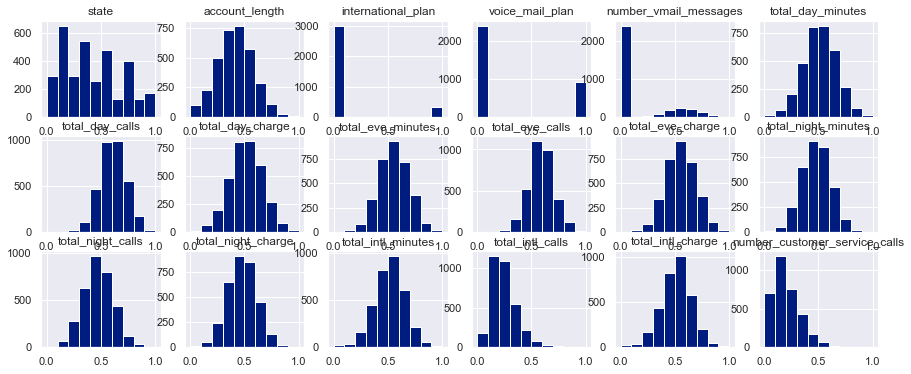

In [31]:
# Verificando se dados seguem distribuição normal

# Construindo dataframe com valores normalizados
df_normal = pd.DataFrame(valores_normalizados, columns = list(dados.columns[0:18]))

# Definindo área de plotagem
fig, ax = plt.subplots(3, 6, figsize = (15, 6))

# Construindo gráficos
contador = 0

for x in range(3):
    for y in range(6):
        ax[x,y].hist(df_normal.iloc[:, contador])
        ax[x,y].set_title(df_normal.columns[contador])
        contador += 1

# Mostrar gráficos
plt.show()

In [ ]:
# Salvando plot
fig.savefig("plots/data-distribution.png")

A maioria das variáveis do dataset segue aproximadamente uma distribuição normal de dados.

Já esperávamos comportamentos diferentes das colunas binárias (international_plan e voice_mail_plan), no entanto, as colunas state, number_vmail_messages e customer_service_calls fogem da distribuição gaussiana, tendendo para distribuições assimétricas positivas (deslocamento à direita).

In [32]:
# Analisando se dados que estão em distribuição normal possuem média = 0 e desvio padrão = 1.
df_normal.describe()[1:3]

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
mean,0.422812,0.413491,0.096910,0.276628,0.158804,0.512472,0.608701,0.512446,0.552599,0.588908,0.552687,0.477870,0.472590,0.478143,0.511865,0.223972,0.511960,0.173651
std,0.267319,0.164554,0.295879,0.447398,0.268399,0.155266,0.121631,0.155255,0.139439,0.117192,0.139459,0.136024,0.137807,0.136035,0.139592,0.123061,0.139588,0.146166


Observamos que as variáveis com distribuição gaussiana não possuem média = 0 e desvio padrão = 1. Nesse sentido, comprova-se a necessidade de padronização.

Isso é importante para algoritmos de regressão (como o que estamos utilizando) e gera ainda melhores resultados se os dados já estiverem normalizados (na mesma escala, procedimento realizado anteriormente).

In [33]:
# Padronização
escala = StandardScaler().fit(valores_normalizados)
escala_pronto = escala.transform(valores_normalizados)

Balanceamento dos dados

In [34]:
# Identificando necessidade de balanceamento dos dados - Tabela
dados.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

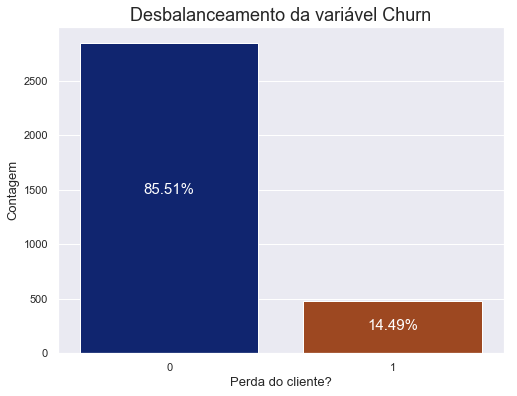

In [35]:
# Identificando necessidade de balanceamento dos dados - Gráfico

# Salvando % de distribuição de churn
churn_dist = dados.churn.value_counts(normalize = True)
no = str(round((churn_dist[0] * 100), 2)) + '%'
yes = str(round((churn_dist[1] * 100), 2)) + '%'

# Definindo área de plotagem
fig, ax = plt.subplots(figsize=(8, 6))

# Construção do gráfico
sns.countplot('churn', data = dados)
ax.set_title('Desbalanceamento da variável Churn', fontsize = 18)
plt.xlabel('Perda do cliente?', fontsize = 13)
plt.ylabel('Contagem', fontsize = 13)
ax.text(0, 1500, no ,fontsize = 15,color = "white", ha = "center", va = 'center')
ax.text(1, 250, yes, fontsize = 15,color = "white", ha = "center", va = 'center')

# Mostrar gráfico
plt.show()

Necessidade de balanceamento identificada.

Um dataset desbalanceado pode aprender muito mais com uma resposta da variável target, gerando um modelo enviesado e trazendo menos confiabilidade para os resultados.

Nesse sentido, balancear a variável target torna-se essencial para alcançarmos modelos de alta performance.

In [ ]:
# Salvando plot
fig.savefig("plots/imbalanced-target.png")

In [36]:
# Balanceamento
target_valores = dados.values[:, 18]
target_valores = target_valores.astype('int64')
balanceador = SMOTE()
escala_pronto, target_balanceado = balanceador.fit_resample(escala_pronto, target_valores)

Analisando colinearidade de atributos

In [37]:
# Construindo matriz de correlação - Tabela
corr = pd.DataFrame(escala_pronto, columns = dados.columns[0:18]).corr(method = 'pearson'); corr

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
state,1.000000,-0.019438,0.054757,-0.039700,-0.037747,0.079211,-0.026135,0.079209,0.020349,0.010818,0.020348,0.002450,-0.005604,0.002430,0.059447,-0.054175,0.059392,0.054514
account_length,-0.019438,1.000000,0.023696,0.015760,0.009080,-0.003967,0.033740,-0.003965,-0.015656,0.024822,-0.015654,-0.046233,-0.030904,-0.046239,-0.000243,0.024220,-0.000255,-0.003767
international_plan,0.054757,0.023696,1.000000,0.044761,0.036932,0.017680,-0.040010,0.017677,0.017661,-0.032027,0.017664,-0.072469,0.028123,-0.072484,0.169371,-0.059637,0.169124,-0.088424
voice_mail_plan,-0.039700,0.015760,0.044761,1.000000,0.963915,-0.106416,-0.024705,-0.106409,-0.036517,-0.002669,-0.036502,-0.050754,0.014580,-0.050799,0.018973,0.044337,0.018959,-0.016801
number_vmail_messages,-0.037747,0.009080,0.036932,0.963915,1.000000,-0.102342,-0.022082,-0.102336,-0.041751,-0.005646,-0.041732,-0.044793,0.003747,-0.044846,0.019840,0.046478,0.019819,-0.010680
total_day_minutes,0.079211,-0.003967,0.017680,-0.106416,-0.102342,1.000000,0.043593,1.000000,0.152181,0.015130,0.152157,0.091479,0.037732,0.091496,-0.002287,0.044178,-0.002034,-0.218222
total_day_calls,-0.026135,0.033740,-0.040010,-0.024705,-0.022082,0.043593,1.000000,0.043588,0.020852,0.011261,0.020853,0.037086,-0.024952,0.037072,-0.009638,0.004438,-0.009520,-0.013302
total_day_charge,0.079209,-0.003965,0.017677,-0.106409,-0.102336,1.000000,0.043588,1.000000,0.152181,0.015131,0.152157,0.091473,0.037736,0.091491,-0.002289,0.044181,-0.002036,-0.218220
total_eve_minutes,0.020349,-0.015656,0.017661,-0.036517,-0.041751,0.152181,0.020852,0.152181,1.000000,-0.005887,1.000000,0.014185,0.040229,0.014172,-0.010263,-0.016075,-0.010264,-0.101337
total_eve_calls,0.010818,0.024822,-0.032027,-0.002669,-0.005646,0.015130,0.011261,0.015131,-0.005887,1.000000,-0.005880,0.009571,-0.001176,0.009588,0.007073,0.044684,0.007108,0.019230


Para facilitar a visualização, vou gerar um mapa de calor a partir da tabela acima de correlação.
Dessa forma, poderemos observar de forma mais clara possíveis atributos colineares.

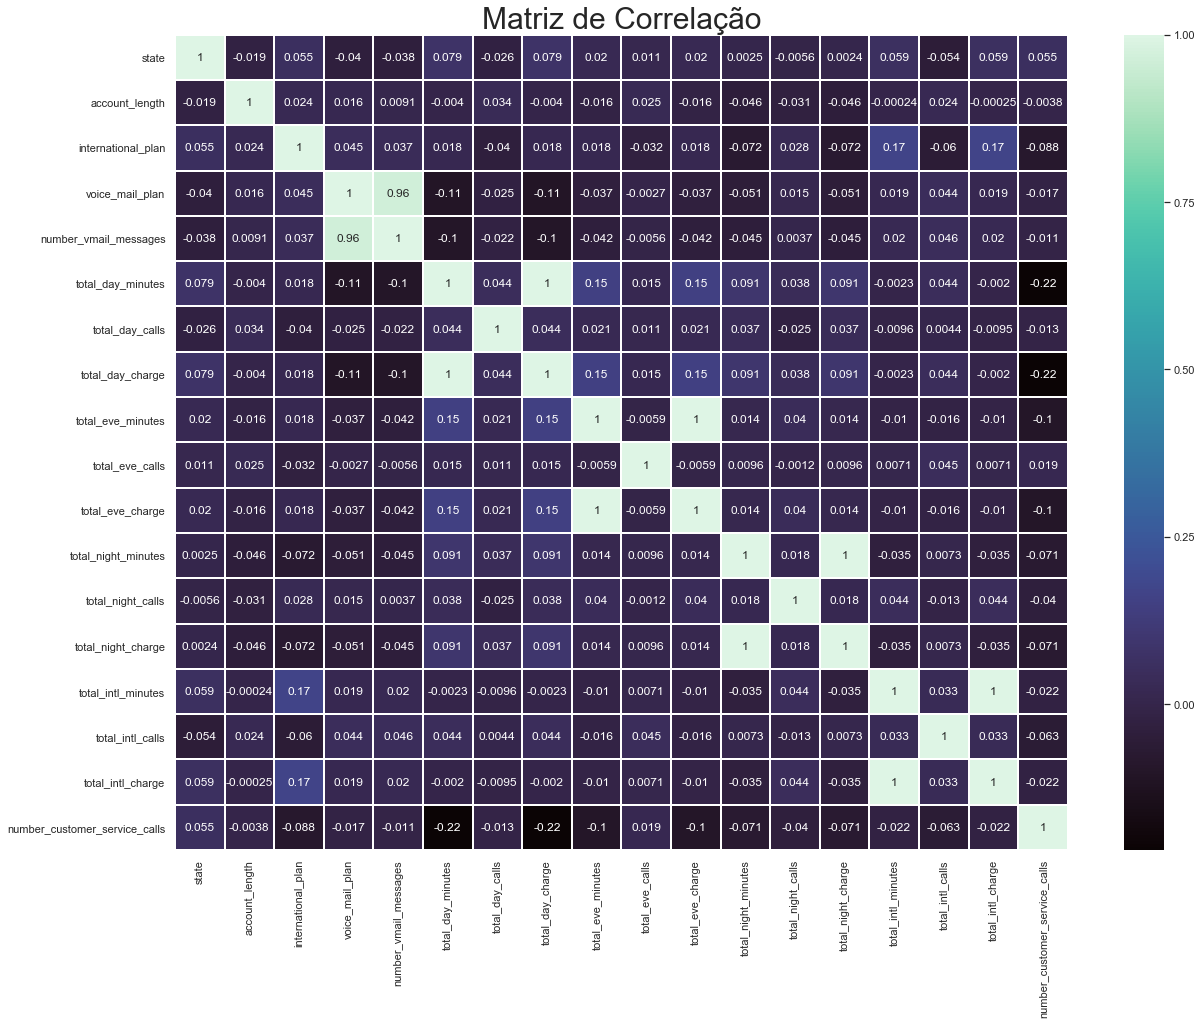

In [38]:
# Construindo matriz de correlação - Gráfico

# Definindo área de plotagem
fig, ax = plt.subplots(figsize = (20, 15))

# construção do gráfico
sns.heatmap(corr, linewidths = 1, annot = True, cmap = 'mako')
ax.set_title('Matriz de Correlação', fontsize = 30)

# Mostrar gráfico
plt.show()

Se observamos além das variáveis correspondentes iguais (correlação = 1 para as variáveis analisadas com elas mesmas), observamos alguns outros coeficientes de correlação muito fortes, que podem afetar o algoritmo.

A fim de identifica-los e retira-los de nosso modelo, vamos utilizar a técnica VIF (Variance Inflation Factor). Neste método, cada variável é selecionada e sofre um processo de regressão em relação às demais variáveis. Os fatores são resultados destas regressões e, se eles forem altos, significam forte correlação. Fatores acima de 5 indicam alta multicolinearidade e as variáveis podem ser prejudiciais ao modelo.

Abaixo vamos calcular o VIF de cada variável do dataset e verificar quais superam 5, retirando-as do dataset para realização do treinamento do modelo.

In [ ]:
# Salvando plot
fig.savefig("plots/correlation-matrix.png")

In [39]:
# Construção de um dataframe com os dados já normalizados e padronizados, unindo com os nomes das colunas
vif_df = pd.DataFrame(escala_pronto, columns = dados.columns[0:18])

# Acrescentando constante na matriz de variáveis
X = add_constant(vif_df)

# Imprimindo VIFs:
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const                            1.179196e+00
state                            1.024141e+00
account_length                   1.007408e+00
international_plan               1.061658e+00
voice_mail_plan                  1.421660e+01
number_vmail_messages            1.419420e+01
total_day_minutes                1.555625e+07
total_day_calls                  1.009268e+00
total_day_charge                 1.555620e+07
total_eve_minutes                2.439572e+06
total_eve_calls                  1.005146e+00
total_eve_charge                 2.439549e+06
total_night_minutes              6.355546e+05
total_night_calls                1.011216e+00
total_night_charge               6.355605e+05
total_intl_minutes               7.470158e+04
total_intl_calls                 1.020684e+00
total_intl_charge                7.469565e+04
number_customer_service_calls    1.081070e+00
dtype: float64

Acima observamos que os VIFs das variáveis 'total_night_minutes', 'total_night_charge', 'total_intl_minutes' e 'total_intl_charge ' superaram 5, então, serão retiradas do dataset.

In [40]:
# Retirando variáveis colineares
escala_pronto = pd.DataFrame(escala_pronto).drop(columns = [11, 13, 14, 16]).values

__Machine Learning__

In [41]:
# Divisão do dataset em dados de treino e dados de teste
x_treino, x_teste, y_treino, y_teste = train_test_split(escala_pronto, target_balanceado,\
                                                        test_size = 0.3)

_Modelo 1 - Logistic Regression com Train-Test-Split comum e sem ajuste de hiper-parâmetros_

In [42]:
# Instanciando Modelo 1 - Logistic Regression
modelo1 = LogisticRegression()

In [43]:
# Treinamento do Modelo 1
modelo1.fit(x_treino, y_treino)

LogisticRegression()

In [44]:
# Fazendo as previsões com Modelo 1
previsoes1 = modelo1.predict(x_teste)

Avaliando o Modelo 1

In [45]:
# Relatório do Modelo 1
print('Relatório de Classificação:\n', classification_report(y_teste, previsoes1, digits=4))
print("Acurácia: %.2f%%" % (accuracy_score(y_teste, previsoes1) * 100))
print('AUC: %.2f' % (roc_auc_score(y_teste, previsoes1)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.7988    0.7538    0.7756       853
           1     0.7680    0.8110    0.7889       857

    accuracy                         0.7825      1710
   macro avg     0.7834    0.7824    0.7823      1710
weighted avg     0.7833    0.7825    0.7823      1710

Acurácia: 78.25%
AUC: 0.78


Explicações e Conclusões - Modelo 1

A acurácia ficou acima de 70%, o que é aceitável para o modelo e problema de negócio.

O recall também mostrou boas porcentagens, mostrando que o balanceamento da variável target funcionou e o modelo aprendeu sem viés para uma das opções de saída.

O AUC também ficou satisfatório, tendo em vista que indica a precisão das previsões e quanto maior, melhor.

No entanto, é valido tentarmos realizar algumas melhorias no algoritmo, como o método Cross Validation.

_Modelo 1 - Logistic Regression com Cross Validation e sem ajuste de hiper-parâmetros_

In [46]:
# Cross Validation com Modelo 1
resultado = cross_val_score(modelo1, escala_pronto, target_balanceado, cv = KFold(5, True))

In [47]:
# Observando acurácia de cada fold
for acuracia in range(5):
    print('Acurácia fold %d: %.2f%%' % ((acuracia.numerator + 1),resultado.take(acuracia) * 100))

Acurácia fold 1: 77.89%
Acurácia fold 2: 76.23%
Acurácia fold 3: 77.37%
Acurácia fold 4: 79.47%
Acurácia fold 5: 79.82%


In [48]:
# Imprimindo média de acurácia - modelo 2
print("Acurácia Final: %.2f%%" % (resultado.mean() * 100))

Acurácia Final: 78.16%


Observamos que o cross validation não funcionou da forma esperada, tendo em vista que a acurácia teve uma leve queda.

Salvando Modelo 1

In [49]:
arquivo1 = 'modelos/modelo_classificador_lr.sav'
pickle.dump(modelo1, open(arquivo1, 'wb'))

_Modelo 2 - Ajustando Hiper-Parâmetros_

O Grid Search Parameter Tuning faz combinações dos parâmetros do algoritmo (neste caso, Regressão Logística).
Os parâmetros são fornecidos à função que cria uma tabela com os melhores valores para os parâmetros testados.

In [50]:
# Definindo os valores e parâmetros que serão testados
valores_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000], \
               'class_weight': ['dict', 'balanced', 'None'], 'solver': ['lbfgs', 'liblinear']}

In [51]:
# Criando o grid e treinando o modelo com todos os parâmetros apresentaados
grid = GridSearchCV(estimator = modelo1, param_grid = valores_grid)
grid.fit(escala_pronto, target_balanceado)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['dict', 'balanced', 'None'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear']})

In [52]:
# Analisando resultados
print("Acurácia: %.3f" % (grid.best_score_ * 100))
print("Melhores Parâmetros do Modelo:\n", grid.best_params_)

Acurácia: 78.333
Melhores Parâmetros do Modelo:
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


Explicações e Conclusões - Modelo 2

Entre valores testados para os parâmetros escolhidos (regra de penalização, força de regularização, pesos das classes e algoritmo interno de otimização), o método mostrou melhores resultados para C = 0.1 e penalidade = l1, peso = balanceado e algoritmo de otimização = liblinear (bom resultado com datasets pequenos). Os valores default para esses parâmetros são, respectivamente, 1, l2, None e lbfgs. 

Mesmo com aparente pequena melhora na acurácia, em um grande conjunto de dados, esses pequenos percentuais podem representar muitos valores presvistos de forma correta. 

Nesse sentido, vou salvar um novo modelo com os valores do resultado acima nos respectivos parâmetros.

Construindo e Treinando Modelo 2 (novo modelo com ajuste de hiper-parâmetros)

In [53]:
# Instanciando modelo com ajuste de hiper-parâmetros
# (utilizando random_state para "embaralhar" os dados)
modelo2 = LogisticRegression(C = 0.1, penalty = 'l1',  solver = 'liblinear', class_weight = 'balanced', random_state = 10)

In [54]:
# Treinamento do Modelo 2
modelo2.fit(x_treino, y_treino)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   random_state=10, solver='liblinear')

Salvando Modelo 2

In [55]:
arquivo2 = 'modelos/modelo_classificador_lr_gridsearchcv.sav'
pickle.dump(modelo2, open(arquivo2, 'wb'))

Conforme observado anteriormente, apesar de resultados adequados, pode ser que a regressão logística não seja o melhor algoritmo para este caso de classificação binária.

Neste sentido, acredito ser válido testar a performance de outros algoritmos como LDA, KNN, Naive Bayes, CART e SVM.

_Modelo 3 - Linear Discriminant Analysis_

In [56]:
# Instanciando Modelo 3 - Linear Discriminant Analysis
modelo3 = LinearDiscriminantAnalysis()

In [57]:
# Treinamento do Modelo 3
modelo3.fit(x_treino, y_treino)

LinearDiscriminantAnalysis()

In [58]:
# Fazendo previsões com o Modelo 3
previsoes3 = modelo3.predict(x_teste)

Avaliando Modelo 3

In [59]:
# Relatório do Modelo 3
print("Relatório de Classificação:\n", classification_report(y_teste, previsoes3, digits=4))
print("Acurácia: %.2f%%" % (accuracy_score(y_teste, previsoes3) * 100))
print('AUC: %.2f' % (roc_auc_score(y_teste, previsoes3)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.8020    0.7597    0.7803       853
           1     0.7727    0.8133    0.7925       857

    accuracy                         0.7865      1710
   macro avg     0.7874    0.7865    0.7864      1710
weighted avg     0.7873    0.7865    0.7864      1710

Acurácia: 78.65%
AUC: 0.79


Explicações e Conclusões - Modelo 3

Aparentemente não houve melhora considerável, tendo em vista que acurácia e AUC permaneceram praticamente iguais.

Salvando Modelo 3

In [60]:
arquivo3 = 'modelos/modelo_classificador_lda.sav'
pickle.dump(modelo3, open(arquivo3, 'wb'))

_Modelo 4 - KNN - K-Nearest Neighbors_

In [61]:
# Instanciando o Modelo 4 - KNN
modelo4 = KNeighborsClassifier()

In [62]:
# Treinamento do Modelo 4
modelo4.fit(x_treino, y_treino)

KNeighborsClassifier()

In [63]:
# Fazendo previsões com o Modelo 4
previsoes4 = modelo4.predict(x_teste)

Avaliando Modelo 4

In [64]:
# Relatório do Modelo 4
print("Relatório de Classificação:\n", classification_report(y_teste, previsoes4, digits=4))
print("Acurácia: %.2f%%" % (accuracy_score(y_teste, previsoes4) * 100))
print('AUC: %.2f' % (roc_auc_score(y_teste, previsoes4)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9843    0.8089    0.8880       853
           1     0.8385    0.9872    0.9068       857

    accuracy                         0.8982      1710
   macro avg     0.9114    0.8980    0.8974      1710
weighted avg     0.9112    0.8982    0.8974      1710

Acurácia: 89.82%
AUC: 0.90


Explicações e Conclusões - Modelo 4

Tanto acurácia como AUC melhoraram de forma expressiva.

Apesar disso, parece que o modelo aprendeu de forma levemente desbalanceada sobre as classes 0 e 1 (recall 0 = 80%, recall 1 = 99%).

Salvando Modelo 4

In [65]:
arquivo4 = 'modelos/modelo_classificador_knn.sav'
pickle.dump(modelo4, open(arquivo4, 'wb'))

_Modelo 5 - Naive Bayes_

In [66]:
# Instanciando Modelo 5 - Naive Bayes
modelo5 = GaussianNB()

In [67]:
# Treinamento do Modelo 5
modelo5.fit(x_treino, y_treino)

GaussianNB()

In [68]:
# Fazendo previsões com o Modelo 5
previsoes5 = modelo5.predict(x_teste)

Avaliando o Modelo 5

In [69]:
print("Relatório de Classificação:\n", classification_report(y_teste, previsoes5, digits=4))
print("Acurácia: %.2f%%" % (accuracy_score(y_teste, previsoes5) * 100))
print('AUC: %.2f' % (roc_auc_score(y_teste, previsoes5)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.8375    0.7796    0.8075       853
           1     0.7948    0.8495    0.8212       857

    accuracy                         0.8146      1710
   macro avg     0.8161    0.8145    0.8144      1710
weighted avg     0.8161    0.8146    0.8144      1710

Acurácia: 81.46%
AUC: 0.81


Explicações e Conclusões - Modelo 5

Apesar de aprender de forma um pouco mais equilibrada sobre as duas classes (observar recall), neste algoritmo observamos a queda da acurácia e da AUC.

Salvando Modelo 5

In [70]:
arquivo5 = 'modelos/modelo_classificador_nb.sav'
pickle.dump(modelo5, open(arquivo5, 'wb'))

_Modelo 6 - CART - Classification and Regression Trees_

In [71]:
# Instanciando Modelo 6 - CART
modelo6 = DecisionTreeClassifier()

In [72]:
# Treinamento do Modelo 6
modelo6.fit(x_treino, y_treino)

DecisionTreeClassifier()

In [73]:
# Fazendo previsões com o Modelo 6
previsoes6 = modelo6.predict(x_teste)

Avaliando Modelo 6

In [74]:
print("Relatório de Classificação:\n", classification_report(y_teste, previsoes6, digits=4))
print("Acurácia: %.2f%%" % (accuracy_score(y_teste, previsoes6) * 100))
print('AUC: %.2f' % (roc_auc_score(y_teste, previsoes6)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9203    0.8664    0.8925       853
           1     0.8743    0.9253    0.8991       857

    accuracy                         0.8959      1710
   macro avg     0.8973    0.8958    0.8958      1710
weighted avg     0.8973    0.8959    0.8958      1710

Acurácia: 89.59%
AUC: 0.90


Explicações e Conclusões - Modelo 6

Utilizando o CART, observamos aumento considerável na acurácia e na AUC, no entanto, ainda encontramos certo desequilíbrio no treinamento das duas classes.

Salvando Modelo 6

In [75]:
arquivo6 = 'modelos/modelo_classificador_cart.sav'
pickle.dump(modelo6, open(arquivo6, 'wb'))

_Modelo 7 - SVM - Support Vector Machines_

In [76]:
# Instanciando Modelo 7 - SVM
modelo7 = SVC(probability = True)

In [77]:
# Treinamento do Modelo 7
modelo7.fit(x_treino, y_treino)

SVC(probability=True)

In [78]:
# Fazendo previsões com o Modelo 7
previsoes7 = modelo7.predict(x_teste)

Avaliando Modelo 7

In [79]:
print("Relatório de Classificação:\n", classification_report(y_teste, previsoes7, digits=4))
print("Acurácia: %.2f%%" % (accuracy_score(y_teste, previsoes7) * 100))
print('AUC: %.2f' % (roc_auc_score(y_teste, previsoes7)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9034    0.8992    0.9013       853
           1     0.9001    0.9043    0.9022       857

    accuracy                         0.9018      1710
   macro avg     0.9018    0.9017    0.9018      1710
weighted avg     0.9018    0.9018    0.9018      1710

Acurácia: 90.18%
AUC: 0.90


Explicações e conclusões - Modelo 7

Parecido com o caso anterior (diferenciando-se apenas na questão do balanceamento das classses), este modelo pareceu ser bastante performático, obtendo excelente acurácia e AUC.

O treinamento para a classe 1 ficou ligeiramente superior se comparado à classe 0, porém, foi o melhor que obtive até o momento.

Salvando Modelo 7

In [80]:
arquivo7 = 'modelos/modelo_classificador_svm.sav'
pickle.dump(modelo7, open(arquivo7, 'wb'))

Modelo escolhido: Modelo 7 - Support Vector Machines (SVM)

Motivo: ótima acurácia e AUC, além de ter aprendido de forma equilibrada sobre as duas classes.

__Previsões com o modelo mais performático, coleta das probabilidades e salvando o trabalho__

In [81]:
# Baixando dados de teste
teste = pd.read_csv('datasets/projeto4_telecom_teste.csv', index_col = 0)

Ajustando dados de teste para igualar estrutura de dados de treino

Criar um pipeline padrão de transformação para os dados de teste

1) transformar coluna state para numérica (churn rate)

2) retirar as colunas area_code, total_night_minutes, total_night_charge, total_intl_minutes e total_intl_charge

3) transformar colunas international_plan, voice_mail_plan em numérica e churn (0 e 1)

4) Normalizar dados

5) padronizar dados

In [82]:
# Função 1 para executar o pipeline
# Preparando dataset completo

def ajuste_dataset_teste (dataset_teste):
    
    global teste
    
    # retirar a coluna area_code
    dataset_teste = dataset_teste.drop(['area_code', 'total_night_minutes', 'total_night_charge', 'total_intl_minutes', \
                                        'total_intl_charge'], axis = 1)

    # substituindo os estados por seus churn rates
    for i in list(dataset_teste.state.values):
        if i in list(churn_rate.state):
            dataset_teste.state.values[dataset_teste.state == i] = churn_rate.rate.values[churn_rate.state == i]
    
    # transformar colunas churn, international_plan e voice_mail_plan em numérica (0 e 1)
    dataset_teste.churn = [1 if item == 'yes' else 0 for item in dataset_teste.churn]
    dataset_teste.international_plan = [1 if item == 'yes' else 0 for item in dataset_teste.international_plan]
    dataset_teste.voice_mail_plan = [1 if item == 'yes' else 0 for item in dataset_teste.voice_mail_plan]
    
    # salvando novo dataset
    teste = dataset_teste

In [83]:
# Aplicando pipeline parte 1 ao dataset de teste
ajuste_dataset_teste(teste)

In [84]:
# Separando preditoras de target
x = teste.values[:, 0:14]
y = teste.values[:, 14]

In [85]:
# Função 2 para executar o pipeline
# Normalizando e padronizando preditoras

def ajuste_preditoras (preditoras):
    
    global x
        
    # normalizando dados
    scaler = MinMaxScaler(feature_range = (0, 1))
    preditoras = scaler.fit_transform(preditoras)
    
    # padronizando dados
    escala2 = StandardScaler().fit(preditoras)
    preditoras = escala2.transform(preditoras)
    
    # salvando novo dataset
    x = preditoras

In [86]:
# Aplicando pipeline parte 1 ao dataset de teste
ajuste_preditoras(x)

In [87]:
# Baixando modelo
modelo = pickle.load(open(arquivo7, 'rb'))

In [88]:
# Gerando previsões com o modelo escolhido
previsoes = modelo.predict(x)

In [89]:
# Coletando e salvando as probabilidades calculadas pelo modelo
probabilidades = modelo.predict_proba(x)

Salvando os resultados

In [93]:
# Previsões
previsoes = pd.DataFrame({'ID': np.arange(1, 1668),'churn': previsoes})
previsoes = previsoes.set_index('ID')
previsoes.to_csv('resultados/previsoes.csv', sep = ';')

In [94]:
# Probabildiades

# churn = 0
prob_0 = round(pd.DataFrame((probabilidades[:, 0] * 100)),2)
prob_0 = list(prob_0[0])

# churn = 1
prob_1 = round(pd.DataFrame((probabilidades[:, 1] * 100)),2)
prob_1 = list(prob_1[0])

prob = pd.DataFrame({'ID': np.arange(1,1668), 'churn=0': prob_0, 'churn=1': prob_1})
prob = prob.set_index('ID')
prob.to_csv('resultados/probabilidades.csv', sep = ';')

__Conclusão__

Antes de ser treinado com um algoritmo de aprendizado de máquina, um conjunto de dados precisa ser detalhadamente analisado para identificação de possíveis problemas como missing data, dados fora de escala, desbalanceamento da variável target, entre outros.

Neste sentido, o trabalho de análise exploratória e pré-processamento de dados torna-se essencial para alta performance com algoritmos de machine learning.

Neste trabalho previmos se um cliente terminaria ou não seu relacionamento com a empresa de telefonia bem como as probabilidades para as duas opções (Sim e Não). 
Foi sugerido o algoritmo de Regressão Logísitca, no entanto, durante os testes, foi observado que outros algoritmos de classificação tiverem performances melhores e, por isso, o escolhido foi o SVM. Com ele obtive melhor acurácia, AUC, além de equilíbrio no aprendizado sobre as duas classes (questão importantíssima para problemas de classificação binária).